## Quantum generative adversarial networks for learning and loading random distributions

### Introduction
Given $k$-dimensional data samples, we employ a quantum Generative Adversarial Network (qGAN) to learn the data's underlying random distribution and to load it directly into a quantum state:

$$ \big| g_{\theta}\rangle = \sum_{j=0}^{2^n-1} \sqrt{p_{\theta}^{j}}\big| j \rangle $$

where $p_{\theta}^{j}$ describe the occurrence probabilities of the basis states $\big| j\rangle$. 

The aim of the qGAN training is to generate a state $\big| g_{\theta}\rangle$ where $p_{\theta}^{j}$, for $j\in \left\{0, \ldots, {2^n-1} \right\}$, describe a probability distribution that is close to the distribution underlying the training data $X=\left\{x^0, \ldots, x^{k-1} \right\}$.

For further details please refer to <a href="https://arxiv.org/abs/1904.00043">Quantum Generative Adversarial Networks for Learning and Loading Random Distributions. Zoufal, Lucchi, Woerner. 2019.</a>

How to use a trained qGAN in an application, i.e., pricing of financial derivatives, is illustrated here:
<a href="../finance/machine_learning/qgan_option_pricing.ipynb">qGAN Option Pricing</a>.

### Imports

In [11]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


import time

start = time.time()

# from torch import optim
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.aqua.components.optimizers import ADAM
from qiskit.aqua.components.uncertainty_models import UniformDistribution, UnivariateVariationalDistribution 
from qiskit.circuit.library import TwoLocal

from qiskit.aqua.algorithms import QGAN
from qiskit.aqua.components.neural_networks.quantum_generator import QuantumGenerator
from qiskit.aqua.components.neural_networks import NumPyDiscriminator, PyTorchDiscriminator

from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.components.initial_states import Custom

from qiskit import BasicAer

### Load the Training Data
First, we need to load the $k$-dimensional training data samples (here k=1). <br/>
Next, the data resolution is set, i.e. the min/max data values and the number of qubits used to represent each data dimension.

### Customize
Use your choice of a pdf as training data or change the parameters of the given bimodal distribution.

In [12]:
# Number training data samples
N = 1000 

# Load data samples from a bimodal distribution

def load_bm_data(N=10000, sig_a=1., mean_a=0.5, sig_b=0.5, mean_b=3.5):
    # Draw N samples from a bimodal (2 Gaussians) distribution.
    data = [sig_a*np.random.randn(N) + mean_a, sig_b*np.random.randn(N) + mean_b]
    return np.array(data).flatten()

# real_data = np.random.lognormal(mean = mu, sigma=sigma, size=N)
real_data = load_bm_data(N=N)

# Set the data resolution
# Set upper and lower data values as list of k min/max data values [[min_0,max_0],...,[min_k-1,max_k-1]]
bounds = np.array([0.,3.]) 
# Set number of qubits per data dimension as list of k qubit values[#q_0,...,#q_k-1]
num_qubits = [2]
k = len(num_qubits)

### Initialize the qGAN
The qGAN consists of a quantum generator $G_{\theta}$, a variational quantum circuit, and a classical discriminator $D_{\phi}$, a neural network. <br/>
To implement the quantum generator, we choose a depth-$1$ variational form that implements $R_Y$ rotations and $CZ$ gates which takes a uniform distribution as an input state. Notably, for $k>1$ the generator's parameters must be chosen carefully. For example, the circuit depth should be $>1$ because higher circuit depths enable the representation of more complex structures.<br/>
The classical discriminator is given by a $3$-layer neural network that applies linear transformations, leaky ReLU functions in the hidden layers and a sigmoid function in the output layer. Notably, the neural network is implemented with PyTorch. Please refer to https://pytorch.org/get-started/locally/ for PyTorch installation instructions.<br/>
Here, both networks are updated with the ADAM optimization algorithm.

### Customize
Change the number of training epochs, batch size and/or the random seed.

In [13]:
# Set number of training epochs
# Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
num_epochs = 30
# Batch size
batch_size = 100

 # Initialize qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)
qgan.seed = 1


### Customize
Use the 'qasm_simulator' instead of the 'statevector_simulator'.

**Advanced:** Load your personal credentials and run the code with an actual Quantum Device or a simulation thereof.

In [14]:
# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(backend=BasicAer.get_backend('statevector_simulator'))

### Customize
Try out different quantum circuits as Ansatz, change the entanglement, the gates, etc.

In [15]:
# Set an initial state for the generator circuit
init_dist = UniformDistribution(sum(num_qubits), low=bounds[0], high=bounds[1])
q = QuantumRegister(sum(num_qubits), name='q')
qc = QuantumCircuit(q)
init_dist.build(qc, q)
init_distribution = Custom(num_qubits=sum(num_qubits), circuit=qc)


# Set entanglement
entanglement = 'linear'
# Choose an Ansatz
var_form = TwoLocal(int(np.sum(num_qubits)), 'ry', 'cz', entanglement=entanglement,
                    reps=3, initial_state=init_distribution)

print(var_form)

# Set generator's initial parameters
init_params = np.random.rand(var_form.num_parameters_settable) * 2 * np.pi
# Set generator circuit
g_circuit = UnivariateVariationalDistribution(int(sum(num_qubits)), var_form, init_params,
                                              low=bounds[0], high=bounds[1])
# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit)

     ┌──────────┐┌──────────┐   ┌──────────┐   ┌──────────┐   ┌──────────┐
q_0: ┤ U2(0,pi) ├┤ RY(θ[0]) ├─■─┤ RY(θ[2]) ├─■─┤ RY(θ[4]) ├─■─┤ RY(θ[6]) ├
     ├──────────┤├──────────┤ │ ├──────────┤ │ ├──────────┤ │ ├──────────┤
q_1: ┤ U2(0,pi) ├┤ RY(θ[1]) ├─■─┤ RY(θ[3]) ├─■─┤ RY(θ[5]) ├─■─┤ RY(θ[7]) ├
     └──────────┘└──────────┘   └──────────┘   └──────────┘   └──────────┘


In [16]:
discriminator = NumPyDiscriminator(len(num_qubits))
# discriminator = PyTorchDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)

### Customize
Try to change the number of nodes and type of activation functions

In [17]:
# Set classical discriminator neural network

class DiscriminatorNet():
    """
    Discriminator

    The neural network is based on a neural network introduced in:
    https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795
    """
 
    def __init__(self, n_features=1, n_out=1):
        """
        Initialize the discriminator network.

        Args:
            n_features (int): Dimension of input data samples.
            n_out (int): output dimension
        """
        self.architecture = [
            {"input_dim": n_features, "output_dim": 50, "activation": "leaky_relu"},
            {"input_dim": 50, "output_dim": 20, "activation": "leaky_relu"},
            {"input_dim": 20, "output_dim": n_out, "activation": "sigmoid"},
        ]

        self.parameters = []
        self.memory = {}

        for _, layer in enumerate(self.architecture):
            activ_function_curr = layer["activation"]
            layer_input_size = layer["input_dim"]
            layer_output_size = layer["output_dim"]
            params_layer = aqua_globals.random.random(layer_output_size * layer_input_size)
            if activ_function_curr == "leaky_relu":
                params_layer = (params_layer * 2 - np.ones(np.shape(params_layer))) * 0.7
            elif activ_function_curr == "sigmoid":
                params_layer = (params_layer * 2 - np.ones(np.shape(params_layer))) * 0.2
            else:
                params_layer = params_layer * 2 - np.ones(np.shape(params_layer))
            self.parameters = np.append(self.parameters, params_layer)
            self.parameters.flatten()

    def forward(self, x):
        """
        Forward propagation.

        Args:
            x (numpy.ndarray): , Discriminator input, i.e. data sample.

        Returns:
            list: Discriminator output, i.e. data label.
        """

        def sigmoid(z):
            sig = 1 / (1 + np.exp(-z))
            return sig

        def leaky_relu(z, slope=0.2):
            return np.maximum(
                np.zeros(np.shape(z)), z) + slope * np.minimum(np.zeros(np.shape(z)), z)

        def single_layer_forward_propagation(x_old, w_new, activation="leaky_relu"):
            z_curr = np.dot(w_new, x_old)

            if activation == "leaky_relu":
                activation_func = leaky_relu
            elif activation == "sigmoid":
                activation_func = sigmoid
            else:
                raise Exception('Non-supported activation function')

            return activation_func(z_curr), z_curr

        x_new = x
        pointer = 0
        for idx, layer in enumerate(self.architecture):
            layer_idx = idx + 1
            activ_function_curr = layer["activation"]
            layer_input_size = layer["input_dim"]
            layer_output_size = layer["output_dim"]
            if idx == 0:
                x_old = np.reshape(x_new, (layer_input_size, len(x_new)))
            else:
                x_old = x_new
            pointer_next = pointer + (layer_output_size * layer_input_size)
            w_curr = self.parameters[pointer:pointer_next]
            w_curr = np.reshape(w_curr, (layer_output_size, layer_input_size))
            pointer = pointer_next
            x_new, z_curr = single_layer_forward_propagation(x_old, w_curr, activ_function_curr)

            self.memory["a" + str(idx)] = x_old
            self.memory["z" + str(layer_idx)] = z_curr

        return x_new

    def backward(self, x, y, weights=None):
        """
        Backward propagation.

        Args:
           x (numpy.ndarray): sample label (equivalent to discriminator output)
           y (numpy.ndarray): array, target label
           weights (numpy.ndarray): customized scaling for each sample (optional)

        Returns:
            tuple(numpy.ndarray, numpy.ndarray): parameter gradients
        """

        def sigmoid_backward(da, z):
            sig = 1 / (1 + np.exp(-z))
            return da * sig * (1 - sig)

        def leaky_relu_backward(da, z, slope=0.2):
            dz = np.array(da, copy=True)
            for i, line in enumerate(z):
                for j, element in enumerate(line):
                    if element < 0:
                        dz[i, j] = dz[i, j] * slope
            return dz

        def single_layer_backward_propagation(da_curr,
                                              w_curr, z_curr, a_prev, activation="leaky_relu"):
            # m = a_prev.shape[1]
            if activation == "leaky_relu":
                backward_activation_func = leaky_relu_backward
            elif activation == "sigmoid":
                backward_activation_func = sigmoid_backward
            else:
                raise Exception('Non-supported activation function')

            dz_curr = backward_activation_func(da_curr, z_curr)
            dw_curr = np.dot(dz_curr, a_prev.T)
            da_prev = np.dot(w_curr.T, dz_curr)

            return da_prev, dw_curr

        grads_values = np.array([])
        m = y.shape[1]
        y = y.reshape(np.shape(x))
        if weights is not None:
            da_prev = - np.multiply(
                weights,
                np.divide(y, np.maximum(np.ones(np.shape(x)) * 1e-4, x))
                - np.divide(1 - y, np.maximum(np.ones(np.shape(x)) * 1e-4, 1 - x)))
        else:
            da_prev = - (np.divide(y, np.maximum(np.ones(np.shape(x)) * 1e-4, x))
                         - np.divide(1 - y, np.maximum(np.ones(np.shape(x)) * 1e-4, 1 - x))) / m

        pointer = 0

        for layer_idx_prev, layer in reversed(list(enumerate(self.architecture))):
            layer_idx_curr = layer_idx_prev + 1
            activ_function_curr = layer["activation"]

            da_curr = da_prev

            a_prev = self.memory["a" + str(layer_idx_prev)]
            z_curr = self.memory["z" + str(layer_idx_curr)]

            layer_input_size = layer["input_dim"]
            layer_output_size = layer["output_dim"]
            pointer_prev = pointer - (layer_output_size * layer_input_size)
            if pointer == 0:
                w_curr = self.parameters[pointer_prev:]
            else:
                w_curr = self.parameters[pointer_prev:pointer]
            w_curr = np.reshape(w_curr, (layer_output_size, layer_input_size))
            pointer = pointer_prev

            da_prev, dw_curr = single_layer_backward_propagation(da_curr,
                                                                 np.array(w_curr), z_curr, a_prev,
                                                                 activ_function_curr)

            grads_values = np.append([dw_curr], grads_values)

        return grads_values
    
discriminator.discriminator_net = DiscriminatorNet(len(num_qubits))

In [18]:
# Run qGAN
qgan.run(quantum_instance)

# Runtime
end = time.time()
print('qGAN training runtime: ', (end - start)/60., ' min')

qGAN training runtime:  2.5293307582537334  min


### Training Progress & Outcome
Now, we plot the evolution of the generator's and the discriminator's loss functions during the training as well as the progress in the relative entropy between the trained and the target distribution.
<br/> Finally, we also compare the cumulative distribution function (CDF) of the trained distribution to the CDF of the target distribution.

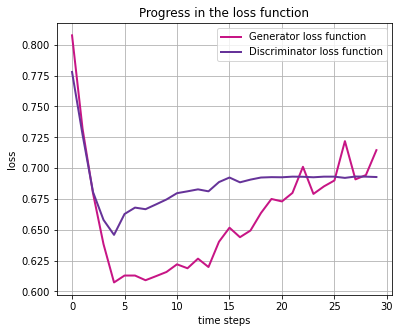

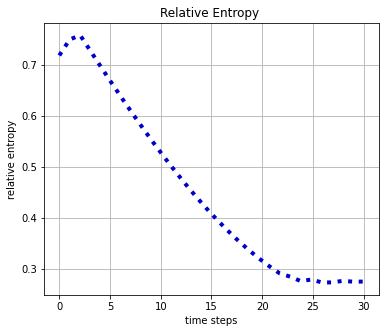

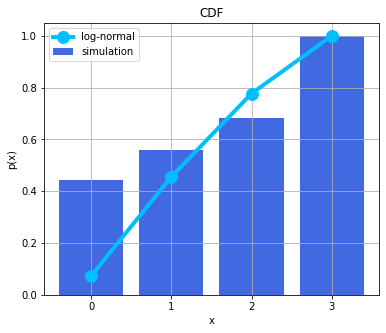

In [19]:
# Plot progress w.r.t the generator's and the discriminator's loss function
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6,5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss, label = "Generator loss function", color = 'mediumvioletred', linewidth = 2)
plt.plot(t_steps, qgan.d_loss, label = "Discriminator loss function", color = 'rebeccapurple', linewidth = 2)
plt.grid()
plt.legend(loc = 'best')
plt.xlabel('time steps')
plt.ylabel('loss')
plt.show()


# Plot progress w.r.t relative entropy
plt.figure(figsize=(6,5))
plt.title("Relative Entropy ")
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr)), qgan.rel_entr, color ='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

#Plot the CDF of the resulting distribution against the target distribution, i.e. log-normal
log_normal = np.random.lognormal(mean=1, sigma=1, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1]+1)):
    temp += [np.sum(log_normal==i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6,5))
plt.title("CDF")
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g,  np.cumsum(prob_g), color='royalblue', width= 0.8, label='simulation')
plt.plot( np.cumsum(log_normal),'-o', label='log-normal', color='deepskyblue', linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g)+1, 1.0))
plt.grid()
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc='best')
plt.show()